In [141]:
# Import required libraries
import pandas as pd
import numpy as np
df = pd.read_csv("train.csv")

In [142]:
df['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [2]:
df.shape

(1460, 81)

In [3]:
df.head(n=5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

# (1) Helper Functions for Pipeline

### Function for Removing Rows

In [4]:
# Given a list of indices (rows) to drop, this returns a copy of the original df without those rows
def remove_rows_from_df(df, list_of_rows_to_drop, printDetails = False):
    df_rows_removed = df.drop(df.index[list_of_rows_to_drop])
    if printDetails:
        print(len(list_of_rows_to_drop),"observations (rows) dropped from dataframe")
        print("Dimensions of new dataframe:", df_rows_removed.shape)
    return df_rows_removed

# Example of usage
list_of_rows_to_remove = [57, 57, 72, 101]
df_with_rows_removed = remove_rows_from_df(df, list_of_rows_to_remove, printDetails = True)

4 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1457, 81)


### Function for Removing Outlier Rows

In [27]:
# Input: dataframe, column name, and threshold for determining if observation is outlier in column
# Ouput: a set whose elements are the indices (rows) of the outliers in this data frame
def indices_of_outliers(df, column_name, stdev_threshold, printDetails = False):
    mask_of_outliers = np.abs(df[column_name] - df[column_name].mean()) >= (stdev_threshold*df[column_name].std())
    set_of_indices_of_outliers = set(df.index[mask_of_outliers].tolist())
    if printDetails:
        print("There are",len(set_of_indices_of_outliers),"outliers in",column_name,"and their indices are:")
        print(set_of_indices_of_outliers)
    return set_of_indices_of_outliers

# "Vectorized" version of set_of_outliers and removes all of them from dataframe
# Non-mutatable, i.e. - original dataframe is not modified. Returns a new dataframe without outliers
def remove_rows_with_outliers(df, list_of_column_names, stdev_threshold, printDetails = False):
    set_of_indices_of_all_outliers = set()
    for column_name in list_of_column_names:
        set_of_indices_of_outliers = indices_of_outliers(df, column_name, stdev_threshold, printDetails)
        if printDetails:
            print("")
        set_of_indices_of_all_outliers = set_of_indices_of_all_outliers.union(set_of_indices_of_outliers)
    list_of_indices_to_drop = list(set_of_indices_of_all_outliers)
    if printDetails:
        print("Dropping outliers based on", stdev_threshold, "standard deviation criteria...")
    df_without_outliers = remove_rows_from_df(df, list_of_indices_to_drop, printDetails)
    return df_without_outliers

# Example of usage
list_of_column_names = ["LotFrontage", "OverallQual"]
df_without_outliers = remove_rows_with_outliers(df, list_of_column_names, stdev_threshold = 3, printDetails = True)

There are 12 outliers in LotFrontage and their indices are:
{197, 934, 807, 231, 1127, 1337, 909, 1298, 1107, 313, 1211, 1182}

There are 2 outliers in OverallQual and their indices are:
{533, 375}

Dropping outliers based on 3 standard deviation criteria...
14 observations (rows) dropped from dataframe
Dimensions of new dataframe: (1446, 81)


### Function for finding where MSSubClass conflicts with HouseStyle, i.e. - we don't know how many floors the house has

In [28]:
# Define two auxiliary functions to help us comb through this data
#   to find conflicts between the labels of the columns "MSSubClass" and "HouseStyle"
def HouseStyle_Value_Count_for_MSSubClass(df, MSSubClass_label, description):
    print("")
    print("#"*75)
    print("For MSSubClass =",MSSubClass_label,"(",description,")","\nThe values & frequencies of HouseStyle are:")
    print(df.loc[df["MSSubClass"]==MSSubClass_label,"HouseStyle"].value_counts())
    print("")

def Find_MSSubClass_HouseStyle_Conflict(df, MSSubClass_label, HouseStyle_label):
    rows_with_conflict = (df["MSSubClass"]==MSSubClass_label) & (df["HouseStyle"]==HouseStyle_label)
    if (sum(rows_with_conflict) >= 1):
        print("Grabbing problematic observations where MSSubClass =",MSSubClass_label,"but","HouseStyle =", HouseStyle_label,"...")
    else:
        raise ValueError("No rows matching this criterion!")
    return rows_with_conflict

# Example of usage
# MSSubClass = 20: 1-STORY 1946 & NEWER ALL STYLES
HouseStyle_Value_Count_for_MSSubClass(df, 20, "1-STORY 1946 & NEWER ALL STYLES")
mask_1 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "2Story")
print(sum(mask_1),"observation(s)")

print("")

mask_2 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "SLvl")
print(sum(mask_2),"observation(s)")


###########################################################################
For MSSubClass = 20 ( 1-STORY 1946 & NEWER ALL STYLES ) 
The values & frequencies of HouseStyle are:
1Story    534
2Story      1
SLvl        1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = 2Story ...
1 observation(s)

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = SLvl ...
1 observation(s)


### Function for finding houses that fail the sanity check, i.e. - square footage of basement = 0 but there is a bathroom in the basement, the renovation date is after the sell date, etc.

In [27]:
def sanity_check(df):
    indexes = []
    indexes.extend(df.index[df["YearRemodAdd"] > df["YrSold"]].tolist())
    indexes.extend(df.index[(df["MasVnrArea"]==0) & (df["MasVnrType"] != "None")].tolist())
    print ("Problematic row indexes:")
    return indexes

# Example
sanity_check(df)

Problematic row indexes:


[523, 688, 1241]

In [9]:
df.loc[df["YearRemodAdd"] > df["YrSold"], ["YearRemodAdd","YrSold","YearBuilt"]]

# Age of house = YearSold - 0.6*YearRemod - 0.4*YrBuilt
# This would produce a negative age
# Proposed solution: add 1.0 year to every single house's age...then this observation would become positive

YearRemodAdd  YrSold  YearBuilt
523          2008    2007       2007

In [35]:
# MasVnrArea = 0, but the MasVnrType is "Stone" or "BrkFace"
x = df.loc[df["MasVnrArea"]==0]
x["MasVnrType"].value_counts()

None       859
BrkFace      1
Stone        1
Name: MasVnrType, dtype: int64

### IMPUTE NA

In [18]:
#### impute NA ####
def impute_na_none(df, columns):
    for col in columns:
        df.loc[df[col].isnull(), col] = "None"
    return df

In [19]:
df_try = df[['Electrical','PoolQC']]
df_try.isnull().sum()

Electrical       1
PoolQC        1453
dtype: int64

In [20]:
columns = ['Electrical','PoolQC']
impute_na_none(df_try, columns)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Electrical PoolQC
0         SBrkr   None
1         SBrkr   None
2         SBrkr   None
3         SBrkr   None
4         SBrkr   None
5         SBrkr   None
6         SBrkr   None
7         SBrkr   None
8         FuseF   None
9         SBrkr   None
10        SBrkr   None
11        SBrkr   None
12        SBrkr   None
13        SBrkr   None
14        SBrkr   None
15        FuseA   None
16        SBrkr   None
17        SBrkr   None
18        SBrkr   None
19        SBrkr   None
20        SBrkr   None
21        FuseF   None
22        SBrkr   None
23        SBrkr   None
24        SBrkr   None
25        SBrkr   None
26        SBrkr   None
27        SBrkr   None
28        SBrkr   None
29        SBrkr   None
...         ...    ...
1430      SBrkr   None
1431      SBrkr   None
1432      SBrkr   None
1433      SBrkr   None
1434      SBrkr   None
1435      SBrkr   None
1436      SBrkr   None
1437      SBrkr   None
1438      FuseA   None
1439      SBrkr   None
1440      SBrkr   None
1441      SBrkr   None
1442      SBrkr   None
1443      FuseF   None
1444      SBrkr   None
1445      SBrkr   None
1446      SBrkr   None
1447      SBrkr   None
1448      SBrkr   None
1449      SBrkr   None
1450      SBrkr   None
1451      SBrkr   None
1452      SBrkr   None
1453      SBrkr   None
1454      SBrkr   None
1455      SBrkr   None
1456      SBrkr   None
1457      SBrkr   None
1458      FuseA   None
1459      SBrkr   None

[1460 rows x 2 columns]

### Function for dummifying categorical variables

In [136]:
def impute_ordinal(df, list_of_dic_to_replace):
    for dic in list_of_dic_to_replace:
        df = df.replace(dic)
    return df

In [126]:
df['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [129]:
dic_to_replace = {"GarageQual": {"Ex": 5, "Gd":5 ,"TA": 4.5, "Fa":2.5, None: 1, "Po": 1}}
df.replace(dic_to_replace)['GarageQual'].value_counts()

4.5    1311
1.0      84
2.5      48
5.0      17
Name: GarageQual, dtype: int64

In [140]:
list_of_dic_to_replace = [
    {"HeatingQC": {"Ex": 3, "Gd":2, "TA": 1.5, "Fa": 1, "Po": 0}},
    {"GarageQual": {"Ex": 5, "Gd":5 ,"TA": 4.5, "Fa":2.5, "None": 1, "Po": 1}}   
]

impute_ordinal(df, list_of_dic_to_replace)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
6        7          20       RL         75.0    10084   Pave   NaN      Reg   
7        8          60       RL          NaN    10382   Pave   NaN      IR1   
8        9          50       RM         51.0     6120   Pave   NaN      Reg   
9       10         190       RL         50.0     7420   Pave   NaN      Reg   
10      11          20       RL         70.0    11200   Pave   NaN      Reg   
11      12          60       RL         85.0    11924   Pave   NaN      IR1   
12      13          20       RL          NaN    12968   Pave   NaN      IR2   
13      14          20       RL         91.0    10652   Pave   NaN      IR1   
14      15          20       RL          NaN    10920   Pave   NaN      IR1   
15      16          45       RM         51.0     6120   Pave   NaN      Reg   
16      17          20       RL          NaN    11241   Pave   NaN      IR1   
17      18          90       RL         72.0    10791   Pave   NaN      Reg   
18      19          20       RL         66.0    13695   Pave   NaN      Reg   
19      20          20       RL         70.0     7560   Pave   NaN      Reg   
20      21          60       RL        101.0    14215   Pave   NaN      IR1   
21      22          45       RM         57.0     7449   Pave  Grvl      Reg   
22      23          20       RL         75.0     9742   Pave   NaN      Reg   
23      24         120       RM         44.0     4224   Pave   NaN      Reg   
24      25          20       RL          NaN     8246   Pave   NaN      IR1   
25      26          20       RL        110.0    14230   Pave   NaN      Reg   
26      27          20       RL         60.0     7200   Pave   NaN      Reg   
27      28          20       RL         98.0    11478   Pave   NaN      Reg   
28      29          20       RL         47.0    16321   Pave   NaN      IR1   
29      30          30       RM         60.0     6324   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1430  1431          60       RL         60.0    21930   Pave   NaN      IR3   
1431  1432         120       RL          NaN     4928   Pave   NaN      IR1   
1432  1433          30       RL         60.0    10800   Pave  Grvl      Reg   
1433  1434          60       RL         93.0    10261   Pave   NaN      IR1   
1434  1435          20       RL         80.0    17400   Pave   NaN      Reg   
1435  1436          20       RL         80.0     8400   Pave   NaN      Reg   
1436  1437          20       RL         60.0     9000   Pave   NaN      Reg   
1437  1438          20       RL         96.0    12444   Pave   NaN      Reg   
1438  1439          20       RM         90.0     7407   Pave   NaN      Reg   
1439  1440          60       RL         80.0    11584   Pave   NaN      Reg   
1440  1441          70       RL         79.0    11526   Pave   NaN      IR1   
1441  1442         120       RM          NaN     4426   Pave   NaN      Reg   
1442  1443          60       FV         85.0    11003   Pave   NaN      Reg   
1443  1444          30       RL          NaN     8854   Pave   NaN      Reg   
1444  1445          20       RL         63.0     8500   Pave   NaN      Reg   
1445  1446          85       RL         70.0     8400   Pave   NaN      Reg   
1446  1447          20       RL          NaN    26142   Pave   NaN      IR1   
1447  1448          60       RL         80.0    10000   Pave   NaN      Reg   
1448  1449          50       RL         70.0    11767   Pa

In [124]:
dic_to_replace = {"HeatingQC": {"Ex": 3, "Gd":2, "TA": 1.5, "Fa": 1, "Po": 0}}
df.replace(dic_to_replace)[['HeatingQC']]

HeatingQC
0           3.0
1           3.0
2           3.0
3           2.0
4           3.0
5           3.0
6           3.0
7           3.0
8           2.0
9           3.0
10          3.0
11          3.0
12          1.5
13          3.0
14          1.5
15          3.0
16          3.0
17          1.5
18          3.0
19          1.5
20          3.0
21          3.0
22          3.0
23          1.5
24          3.0
25          3.0
26          1.5
27          3.0
28          1.5
29          1.0
...         ...
1430        3.0
1431        1.5
1432        1.5
1433        3.0
1434        1.0
1435        1.5
1436        1.5
1437        3.0
1438        1.5
1439        1.5
1440        1.0
1441        3.0
1442        3.0
1443        1.0
1444        3.0
1445        2.0
1446        1.5
1447        3.0
1448        2.0
1449        3.0
1450        1.5
1451        3.0
1452        2.0
1453        3.0
1454        3.0
1455        3.0
1456        1.5
1457        3.0
1458        2.0
1459        2.0

[1460 rows x 1 columns]

In [40]:
df['HeatingQC'].head()

0    3.0
1    3.0
2    3.0
3    2.0
4    3.0
Name: HeatingQC, dtype: float64

In [104]:
grouped = df.groupby('LotShape')[['LotShape']].agg('count').rename(columns={'LotShape':'count'}).sort_values(by = "count", ascending = False)
grouped

count
LotShape       
Reg         925
IR1         484
IR2          41
IR3          10

In [63]:
### LotShape ### manually ###
try1 = pd.get_dummies(df, columns=['LotShape'], prefix='LotShape', prefix_sep='_') 
try1.drop(columns = ['LotShape_IR2', 'LotShape_IR3'], inplace = True)

In [64]:
try1.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeck

In [89]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [114]:
def dummify_categorical(df, columns):
    for col in columns:
        # value_counts (sort by frequency)
        grouped = df.groupby(col)[[col]].agg('count').rename(columns={col:'count'}).sort_values(by = "count", ascending = False)
        
        # dummify all categories
        df = pd.get_dummies(df, columns=[col], prefix=col, prefix_sep='_') 
        
        # categories with frequency less than 70
        columns_to_drop = list(grouped.loc[grouped['count']<70].index)
        columns_to_drop = [col + "_" + i for i in columns_to_drop]
        
        # drop dummified columns
        if len(columns_to_drop) > 0:
            df = df.drop(columns = columns_to_drop,axis = 1)
        else:
            # when all the categories have frequency higher than 70
            df = df.drop(col + "_" + grouped.index[0], axis=1)
    return df

In [116]:
# how the function works
columns = ['LotShape', "BsmtFinType1"]
dummify_categorical(df, columns)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0        1          60       RL         65.0     8450   Pave   NaN   
1        2          20       RL         80.0     9600   Pave   NaN   
2        3          60       RL         68.0    11250   Pave   NaN   
3        4          70       RL         60.0     9550   Pave   NaN   
4        5          60       RL         84.0    14260   Pave   NaN   
5        6          50       RL         85.0    14115   Pave   NaN   
6        7          20       RL         75.0    10084   Pave   NaN   
7        8          60       RL          NaN    10382   Pave   NaN   
8        9          50       RM         51.0     6120   Pave   NaN   
9       10         190       RL         50.0     7420   Pave   NaN   
10      11          20       RL         70.0    11200   Pave   NaN   
11      12          60       RL         85.0    11924   Pave   NaN   
12      13          20       RL          NaN    12968   Pave   NaN   
13      14          20       RL         91.0    10652   Pave   NaN   
14      15          20       RL          NaN    10920   Pave   NaN   
15      16          45       RM         51.0     6120   Pave   NaN   
16      17          20       RL          NaN    11241   Pave   NaN   
17      18          90       RL         72.0    10791   Pave   NaN   
18      19          20       RL         66.0    13695   Pave   NaN   
19      20          20       RL         70.0     7560   Pave   NaN   
20      21          60       RL        101.0    14215   Pave   NaN   
21      22          45       RM         57.0     7449   Pave  Grvl   
22      23          20       RL         75.0     9742   Pave   NaN   
23      24         120       RM         44.0     4224   Pave   NaN   
24      25          20       RL          NaN     8246   Pave   NaN   
25      26          20       RL        110.0    14230   Pave   NaN   
26      27          20       RL         60.0     7200   Pave   NaN   
27      28          20       RL         98.0    11478   Pave   NaN   
28      29          20       RL         47.0    16321   Pave   NaN   
29      30          30       RM         60.0     6324   Pave   NaN   
...    ...         ...      ...          ...      ...    ...   ...   
1430  1431          60       RL         60.0    21930   Pave   NaN   
1431  1432         120       RL          NaN     4928   Pave   NaN   
1432  1433          30       RL         60.0    10800   Pave  Grvl   
1433  1434          60       RL         93.0    10261   Pave   NaN   
1434  1435          20       RL         80.0    17400   Pave   NaN   
1435  1436          20       RL         80.0     8400   Pave   NaN   
1436  1437          20       RL         60.0     9000   Pave   NaN   
1437  1438          20       RL         96.0    12444   Pave   NaN   
1438  1439          20       RM         90.0     7407   Pave   NaN   
1439  1440          60       RL         80.0    11584   Pave   NaN   
1440  1441          70       RL         79.0    11526   Pave   NaN   
1441  1442         120       RM          NaN     4426   Pave   NaN   
1442  1443          60       FV         85.0    11003   Pave   NaN   
1443  1444          30       RL          NaN     8854   Pave   NaN   
1444  1445          20       RL         63.0     8500   Pave   NaN   
1445  1446          85       RL         70.0     8400   Pave   NaN   
1446  1447          20       RL          NaN    26142   Pave   NaN   
1447  1448          60       RL         80.0    10000   Pave   NaN   
1448  1449          50       RL         70.0    11767   Pave   NaN   
1449  1450         180       RM         21.0     1533   Pave   NaN   
1450  1451          90       RL         60.0     9000   Pave   NaN   
1451  1452          20       RL         78.0     9262   Pave   NaN   
1452  1453         180       RM         35.0     3675   Pave   NaN   
1453  1454          20       RL         90.0    17217   Pave   NaN   
1454  1455          20       FV         62.0     7500   Pave  Pave   
1455  1456        

In [8]:
??????????????

Object `????????????` not found.


In [36]:
df["BsmtQual"].head(n=10)

0    Gd
1    Gd
2    Gd
3    TA
4    Gd
5    Gd
6    Ex
7    Gd
8    TA
9    TA
Name: BsmtQual, dtype: object

In [37]:
df["BsmtQual"].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [38]:
BsmtQual_dict = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}
df["BsmtQual_numeric"] = [BsmtQual_dict[x] for x in df["BsmtQual"].values]
pd.get_dummies(df, prefix=["BsmtQual"])

KeyError: nan

# (2) Actual Pipeline Using Helper Functions

### Remove outliers for all numeric features (columns)

In [ ]:
list_of_column_names = [???????????]
df_without_outliers = remove_rows_with_outliers(df, list_of_column_names, stdev_threshold = 3, printDetails = False)

### Remove rows where MSSubClass conflicts with HouseStyle.  Just showing this for cases where MSSubClass = 20.  We need to continue searching for all cases, such as MSSubClass = 30, 40, etc...

# Training Linear Regression Model

In [69]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from math import sqrt
from statistics import mean 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [70]:
### Alice ###
X = df[list_of_predictors]
y = df["SalePrice"]

In [71]:
### Alice ###
#transformation
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [72]:
list_of_predictors = ["GrLivArea", "LotArea", "OverallQual"]

In [73]:
### Alice ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
### Alice's Pipeline for training model ###
n_splits = 5

list_of_exponents = list(range(-2,4))
alpha_vector = np.power(10.0, list_of_exponents)
RMSE_vector = []

for alpha in alpha_vector:
    
    RMSE_per_fold = []
    kf = KFold(n_splits = 5, shuffle = True)
    
    for train_index, test_index in kf.split(X_train):
        X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
        y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

        lasso_model = linear_model.Lasso(alpha = alpha)
        lasso_model.fit(X_train_kf, y_train_kf)
        y_test_predicted = lasso_model.predict(X_test_kf)
        RMSE = sqrt(mean_squared_error(y_test_kf, y_test_predicted))
        R2 = r2_score(y_test_kf, y_test_predicted)
        RMSE_per_fold.append(RMSE)
        
    RMSE_for_given_alpha = mean(RMSE_per_fold)
    RMSE_vector.append(RMSE_for_given_alpha)
    
    print("For alpha =",alpha)
    print("RMSE = ", '{:,.0f}'.format(RMSE_for_given_alpha))
    print("")

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [50]:
### Joe's Pipeline for training model ###
n_splits = 5

list_of_exponents = list(range(-2,4))
alpha_vector = np.power(10.0, list_of_exponents)
RMSE_vector = []

for alpha in alpha_vector:
    
    RMSE_per_fold = []
    kf = KFold(n_splits = n_splits, shuffle = True)
    
    for train_index, test_index in kf.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lasso_model = linear_model.Lasso(alpha = alpha)
        lasso_model.fit(X_train, y_train)
        y_test_predicted = lasso_model.predict(X_test)
        RMSE = sqrt(mean_squared_error(y_test, y_test_predicted))
        R2 = r2_score(y_test, y_test_predicted)
        #print("R-squared=",R2)
        #print("RMSE =",'{:,.0f}'.format(RMSE))
        #print("")
        #print(lasso_model.coef_)
        RMSE_per_fold.append(RMSE)
    
    RMSE_for_given_alpha = mean(RMSE_per_fold)
    RMSE_vector.append(RMSE_for_given_alpha)
    
    print("For alpha =",alpha)
    print("RMSE = ", '{:,.0f}'.format(RMSE_for_given_alpha))
    print("")

print(alpha_vector)
print(RMSE_vector)


KeyError: '[   0    1    4 ... 1454 1455 1458] not in index'

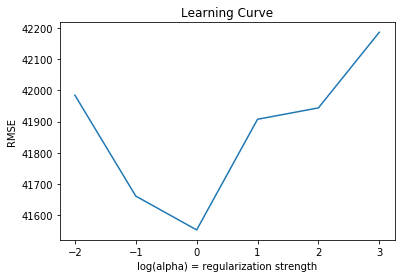

In [47]:
import matplotlib.pyplot as plt

plt.plot(list_of_exponents, RMSE_vector)
plt.title("Learning Curve")
plt.xlabel('log(alpha) = regularization strength')
plt.ylabel('RMSE')
plt.show()

In [ ]:
### May ###
# Using 80% of train dataset to find the best lambda 
n_splits = 5 # number of folds 
list_of_exponents = np.linspace(-10,3,20)
alpha_vector = np.power(10.0, list_of_exponents) # vector of alpha/lambda 
RMSE_vector = []
selected_model = Lasso()
for alpha in alpha_vector:
    RMSE_per_fold = []
    kf = KFold(n_splits = n_splits, shuffle = True)
    for train_index, test_index in kf.split(X_train):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train_KF, X_test_KF = X_train[train_index], X_train[test_index]
        y_train_KF, y_test_KF = y_train[train_index], y_train[test_index]
        selected_model.set_params(alpha = alpha)
        selected_model.fit(X_train_KF, y_train_KF)
        y_test_KF_predicted = selected_model.predict(X_test_KF)
        RMSE = sqrt(mean_squared_error(y_test_KF, y_test_KF_predicted))
        R2 = r2_score(y_test_KF, y_test_KF_predicted)
        #print("R-squared=",R2)
        #print("RMSE =",'{:,.0f}'.format(RMSE))
        #print("")
        #print(lasso_model.coef_)
        RMSE_per_fold.append(RMSE)
    RMSE_for_given_alpha = mean(RMSE_per_fold)
    RMSE_vector.append(RMSE_for_given_alpha)
    print("For alpha =",alpha)
    print("RMSE = ", '{:,.0f}'.format(RMSE_for_given_alpha))
    print("")
print(alpha_vector)
print(RMSE_vector)